In [100]:
import pandas as pd
import numpy as np
from DBapi import get_option_data, get_options_info, get_index_price
import matplotlib.pyplot as plt
from datetime import date
import datetime
from scipy.optimize import minimize
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn' заглушить SettingWithCopyWarning
from IPython.display import display, Math #для красивых символов

In [255]:
contract_names=get_options_info()

Processing time: 0.42194199562072754


In [256]:
df=get_option_data(contract_names['instrument_name'])

Processing time: 52.36158990859985


In [257]:
df_clear=df.drop(['underlying_index', 'state',
       'settlement_price', 'open_interest', 'min_price', 'max_price',
       'last_price', 'interest_rate',
       'index_price', 'estimated_delivery_price',
       'change_id', 'bids', 'bid_iv', 'best_bid_amount',
       'best_ask_amount', 'asks', 'ask_iv', 'stats.volume',
       'stats.price_change', 'stats.low', 'stats.high', 'greeks.vega',
       'greeks.theta', 'greeks.rho', 'greeks.gamma', 'greeks.delta'], axis=1)

In [258]:
df_clear=df_clear.merge(contract_names[['instrument_name','expiration_timestamp']])
df_clear['strike'] = df_clear.instrument_name.map(lambda x: int(x.split('-')[2]))
df_clear['type'] = df_clear.instrument_name.map(lambda x: x.split('-')[3])
df_clear=df_clear.rename(columns={'expiration_timestamp':'date_strike'})

df_clear['T_strike']=(pd.to_datetime(df_clear.date_strike)-datetime.datetime.now()).dt.days/365

df_clear['date_strike']=df_clear.date_strike.map(lambda x: date(int(x[:4]), int(x[5:7]), int(x[-2:])) )
df_clear['time_to_exp']=(df_clear.date_strike-dt.datetime.today().date()).dt.days / 365

In [290]:
class SABR:
    def __init__(self, data: pd.DataFrame):
        self.data = data

        self.beta = 0.5

        self.T = data.time_to_exp.iloc[0]
        self.x0 = np.array([0.99, 0.00, 0.99])
        self.bounds = [(0.0001, 1000.0), (-0.9999, 0.9999), (0.0001, 1000.0)]

   

    def sigma_b(self, f: float, K: float, T: float, alpha: float, rho: float, v: float):
        
        numerator1 = ( (1 - self.beta) ** 2 / 24 * alpha**2 / (f * K) ** (1 - self.beta) )
        numerator2 = ( (rho * self.beta * v * alpha) / 4 * (f * K) ** ((1 - self.beta) / 2) )
        numerator3 = (2 - 3 * rho**2) * v**2 / 24
        
        numerator = alpha * (1+ self.T * (numerator1 + numerator2 + numerator3) )

        denominator1 = (1 - self.beta) ** 2 / 24 * (np.log(f / K)) ** 2
        denominator2 = (1 - self.beta) ** 4 / 1920 * (np.log(f / K)) ** 4
        
        denominator = (f * K) ** ((1 - self.beta) / 2) * (1 + denominator1 + denominator2)

        z = v / alpha * (f * K) ** ((1 - self.beta) / 2) * np.log(f / K)

        xi = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))

        return numerator / denominator * z / xi

    def plot_vol(self):
        
        def set_vols(alpha: float, rho: float, v: float):
            volatilities = []
            for index, row in self.data.iterrows():
                sigma_modeled = self.sigma_b(
                    row.underlying_price, row.strike, self.T, alpha, rho, v
                )
                volatilities.append(sigma_modeled)
            return volatilities

        self.data["vol_b"] = set_vols(
            self.alpha_scipy, self.rho_scipy, self.v_scipy
        )
        

        fig, ax = plt.subplots(figsize=(15, 7))
        ax = sns.lineplot(
            x="strike", y="vol_b", data=self.data, label="SABR vol"
        )
        
        ax2 = sns.scatterplot(
            x="strike",
            y="mark_iv",
            data=self.data,
            label="Deribit vol",
            color="red"
        ).set_title("SABR volatility")
        ax.grid()
        plt.rcParams["figure.autolayout"] = True
        plt.xlabel('Страйк цена К, USD',fontsize =14)
        plt.ylabel('Вменённая волатильность $\sigma_{impl}$',fontsize =14)

    def vol_MSE(self, x: np.ndarray):
        smile = self.data.mark_iv.to_numpy()
        vols = []
        for index, row in self.data.iterrows():
            vols.append(
                self.sigma_b(
                    row["underlying_price"], row["strike"], self.T, x[0], x[1], x[2]
                )
            )
        return sum((vols - smile) ** 2)

    
    def minimize_scipy(self):
        return minimize(self.vol_MSE, x0=self.x0, bounds=self.bounds)

    def run(self):
        optimum_scipy = self.minimize_scipy()
        self.alpha_scipy, self.rho_scipy, self.v_scipy = optimum_scipy.x
        print('Yielded parameters:')
        display(Math(r' \alpha ={}, \>  \rho ={},\> \nu = {}'.format(round(self.alpha_scipy,3),\
                                                                    round(self.rho_scipy,5),\
                                                                    round(self.v_scipy,3)) ))
        self.plot_vol()

In [291]:
df_clear.date_strike.unique()

array([datetime.date(2022, 11, 11), datetime.date(2022, 11, 12),
       datetime.date(2022, 11, 18), datetime.date(2022, 11, 25),
       datetime.date(2022, 12, 2), datetime.date(2022, 12, 30),
       datetime.date(2023, 1, 27), datetime.date(2023, 3, 31),
       datetime.date(2023, 6, 30), datetime.date(2023, 9, 29)],
      dtype=object)

Yielded parameters:


<IPython.core.display.Math object>

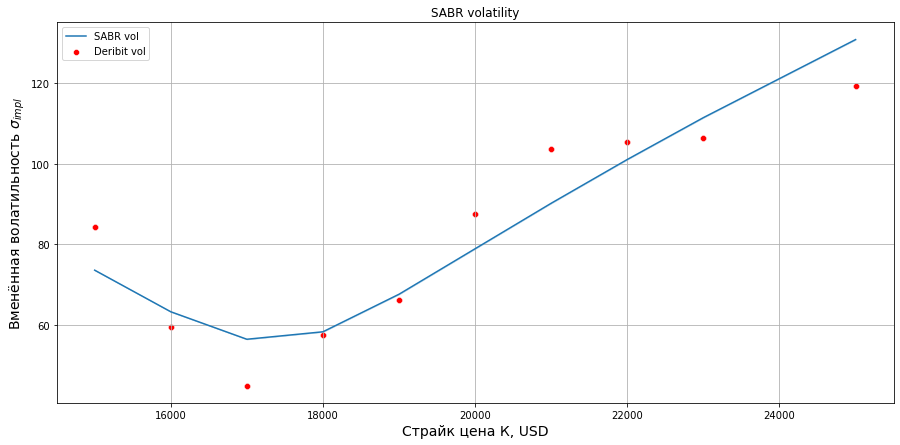

In [292]:
maturity=datetime.date(2022, 11, 18)
sabr = SABR(df_clear[df_clear.date_strike==maturity])
sabr.run()